In [23]:
from data import NYUDataset
import yaml
import sys
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import yaml
import os
import logging
from tqdm import tqdm
from torchvision.transforms import v2 as t
from torchvision import transforms
from torchvision.datasets import VisionDataset

from architecture import build_METER_model
from augmentation import CShift, DShift, augmentation2D
from loss import balanced_loss_function
from metrics import REL, RMSE, delta
import matplotlib.pyplot as plt

def load_config(config_path):
    """Load configuration from YAML file."""
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

config = load_config('./config.yaml')

dataset = NYUDataset(
    root=config['data']['root'],
    test=False,
    transforms=t.Compose([
        t.ToImage(),
        t.ToDtype(torch.float32, scale=True),  # scale to [0, 1]
        ])
)
dataloader = DataLoader(dataset, 1)



/mnt/data/nyu/nyu_data/data


In [24]:
def load_checkpoint(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    if "model_state_dict" in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
    else:
        model.load_state_dict(checkpoint)
    
    return model

model = build_METER_model("cuda", arch_type=config['model']['variant'])
# load_checkpoint(model, './checkpoints_first/best_model.pth')
load_checkpoint(model, 'models/build_model_best_nyu_s')
model = model.to("cuda")
model = model.eval()


In [25]:
import numpy as np
from torch import Tensor
from PIL import Image


def tensor_to_image(x: Tensor, rgb=False):
    # np_image = x.permute(0, 1).numpy()
    if x.get_device() >= 0:
        x = x.cpu()

    if rgb:
        x = x.permute((1, 2, 0))
    
    np_image = x.numpy()
    # 3. Convert to uint8 (for displaying as an image)
    np_image = (np_image).astype(np.uint8)

    # 4. Create PIL Image
    pil_image = Image.fromarray(np_image, "RGB" if rgb else None)

    # 5. Display using matplotlib inline in notebook
    plt.imshow(pil_image)
    plt.axis('off')
    plt.show()

In [26]:
def show_nth_dataset(model, dataset, n):
    img, depth = dataset[0]
    img = img.unsqueeze(0).to(device="cuda")
    depth = depth.unsqueeze(0).to(device="cuda")
    with torch.no_grad():
        output = model(img)
    print(img.shape)
    print(depth.shape)
    print(output.shape)
    tensor_to_image(img.squeeze(dim=(0,1)), True)
    tensor_to_image(depth.squeeze(dim=(0,1)))
    tensor_to_image(output.squeeze(dim=(0,1)))

torch.Size([1, 3, 192, 256])
torch.Size([1, 1, 480, 640])
torch.Size([1, 1, 48, 64])


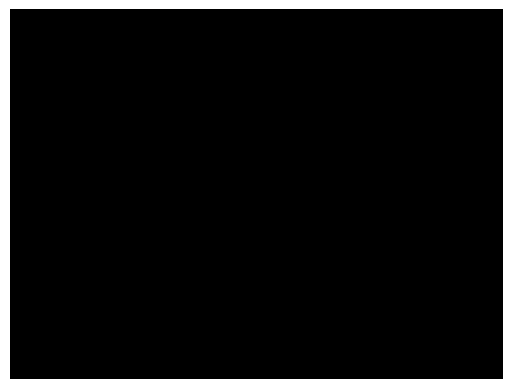

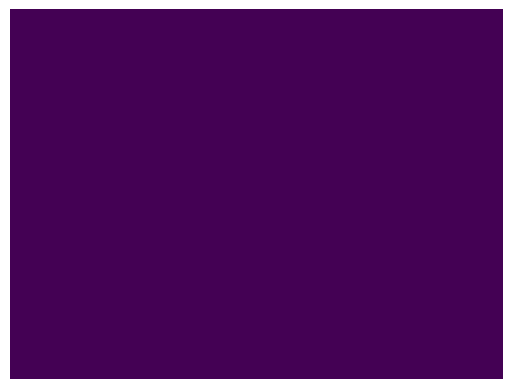

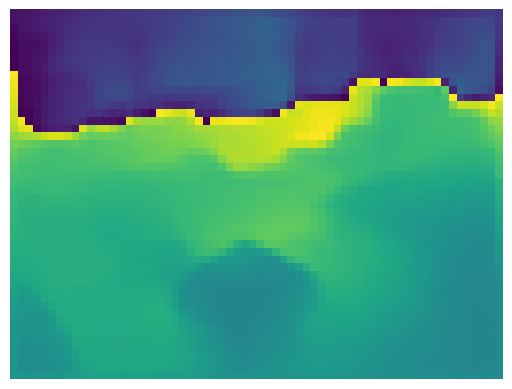

In [27]:
import random

show_nth_dataset(model, dataset, n=random.randint(0, len(dataset)))